# Time Series Analysis on Warner Bros Discovery Stock Price  

This is my first project with time series.

Notebook based on the Kaggle "Time Series" lessons: https://www.kaggle.com/learn/time-series

Dataset: https://finance.yahoo.com/quote/WBD/history?p=WBD  

Period: January 07 2022 - January 07 2023

# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_style("darkgrid")
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (15, 5)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

import warnings
warnings.simplefilter(action='ignore')

In [2]:
import yfinance as yf
stock_symbol = 'WBD' ##change to any ticker of your choice
warner = yf.download(tickers = stock_symbol,period ='1y',interval ='1d')

[*********************100%***********************]  1 of 1 completed


In [3]:
# warner = pd.read_csv('./warner_bros.csv', parse_dates=['Date'], index_col='Date').drop(
#     columns=['Open', 'High', 'Low', 'Adj Close', 'Volume']).rename(columns={'Close':'Closing Price'})

# warner.info()

In [4]:
warner.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'],inplace=True)

In [5]:
warner.rename(columns={'Close':'Closing Price'},inplace=True)

In [6]:
warner.index

DatetimeIndex(['2022-01-10', '2022-01-11', '2022-01-12', '2022-01-13',
               '2022-01-14', '2022-01-18', '2022-01-19', '2022-01-20',
               '2022-01-21', '2022-01-24',
               ...
               '2022-12-23', '2022-12-27', '2022-12-28', '2022-12-29',
               '2022-12-30', '2023-01-03', '2023-01-04', '2023-01-05',
               '2023-01-06', '2023-01-09'],
              dtype='datetime64[ns]', name='Date', length=251, freq=None)

# Plotting the Data

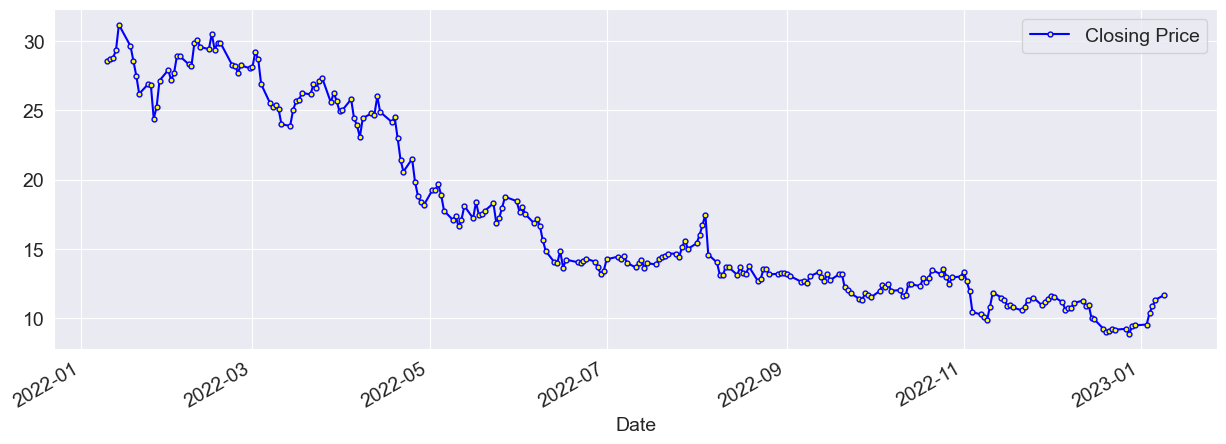

In [7]:
warner.plot(color='blue', marker='o', markersize=3.5, markerfacecolor='yellow');

# Trend  

Discovering the trend.

## Moving Average Plot Computation  

It does not seem to be a particular seasonality in the stocks' closing price.  
So, some different moving averages will be plotted to choose the smoothest one.  

Source: https://mins.space/blog/2020-06-29-moving-average-effect-window-size/

Creating a moving average function.

In [8]:
def moving_plotter(size, ax):
    # Creating the Moving Average
    mov_av = warner.rolling(
        window=size,
        center=True,
        min_periods=round(size/2)
    ).mean()
    mov_av['Trend'] = mov_av['Closing Price']
    mov_av.drop(columns='Closing Price', inplace=True)
    
    # Plotting it
    warner.plot(marker='o', color='grey', ax=ax)
    mov_av.plot(color='red', ax=ax);

Plotting different values.

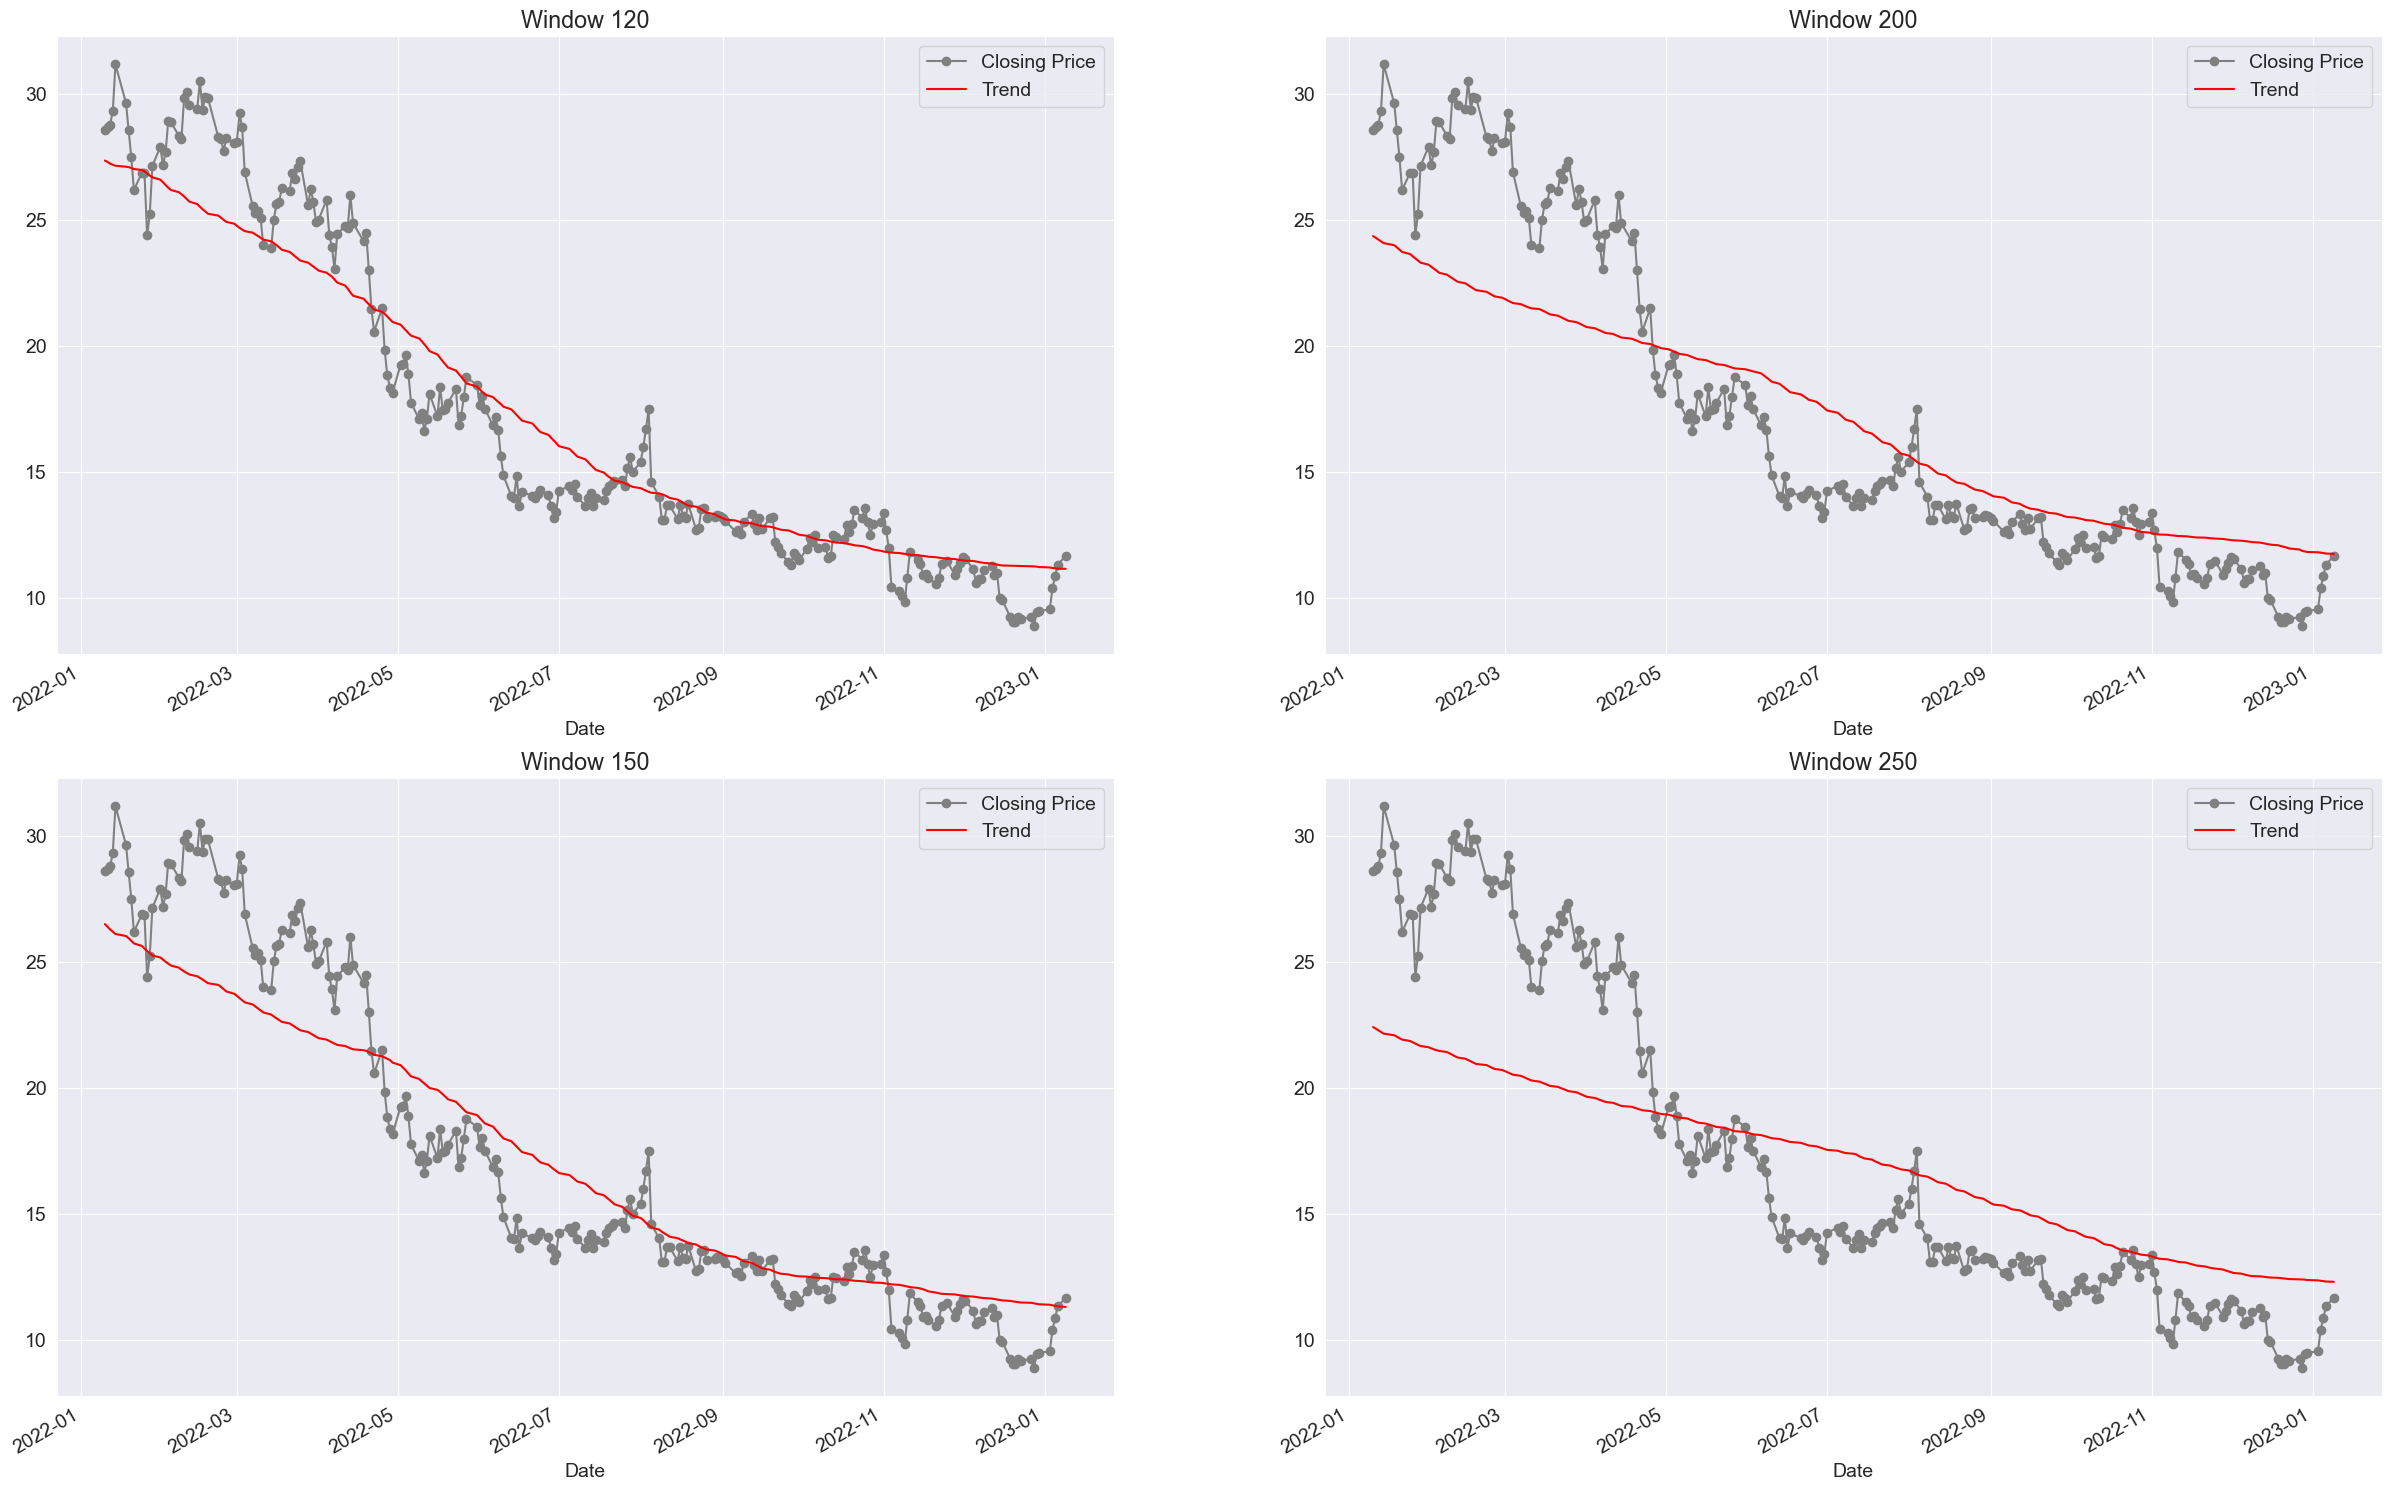

In [9]:
fig, axes = plt.subplots(2,2, figsize=(30,20))

axes[0,0].set_title('Window 120')
moving_plotter(120, axes[0,0])

axes[1,0].set_title('Window 150')
moving_plotter(150, ax=axes[1,0])

axes[0,1].set_title('Window 200')
moving_plotter(200, ax=axes[0,1])

axes[1,1].set_title('Window 250')
moving_plotter(250, ax=axes[1,1])

A 120 window seems to fit the trend well.

## Deterministic Process  

It will be used to make predictions about the trend and trying some forecasts.

In [10]:
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(
    index=warner.index,
    constant=True,
    order=2,
    drop=True
)

X = dp.in_sample()

In [11]:
X

,const,trend,trend_squared
Date,,,
2022-01-10,1.0,1.0,1.0
2022-01-11,1.0,2.0,4.0
2022-01-12,1.0,3.0,9.0
2022-01-13,1.0,4.0,16.0
2022-01-14,1.0,5.0,25.0
...,...,...,...
2023-01-03,1.0,247.0,61009.0
2023-01-04,1.0,248.0,61504.0
2023-01-05,1.0,249.0,62001.0


In [12]:
y = warner['Closing Price']

from sklearn.linear_model import LinearRegression

model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.DataFrame(model.predict(X), columns=['Trend'], index=X.index)

In [13]:
y_pred

,Trend
Date,
2022-01-10,31.562595
2022-01-11,31.387704
2022-01-12,31.213548
2022-01-13,31.040129
2022-01-14,30.867445
...,...
2023-01-03,10.714537
2023-01-04,10.720667
2023-01-05,10.727534


In [14]:
y

Date
2022-01-10    28.590000
2022-01-11    28.680000
2022-01-12    28.790001
2022-01-13    29.340000
2022-01-14    31.180000
                ...    
2023-01-03     9.540000
2023-01-04    10.380000
2023-01-05    10.860000
2023-01-06    11.320000
2023-01-09    11.665000
Name: Closing Price, Length: 251, dtype: float64

Plotting the results.

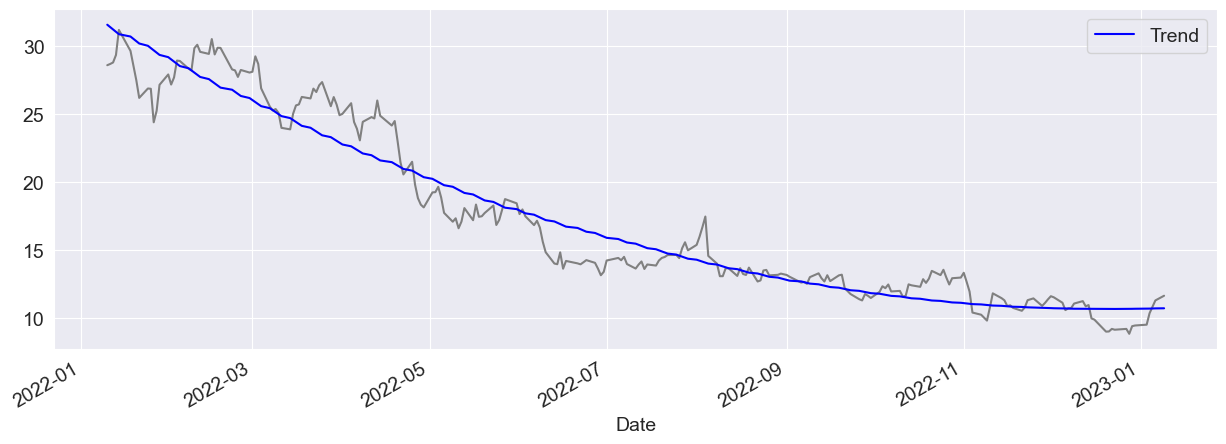

In [15]:
fig, ax = plt.subplots()

y.plot(color='grey', ax=ax)

y_pred.plot(color='blue', ax=ax);

Making forecasts.

In [16]:
X_fore = dp.out_of_sample(steps=30)
y_fore = pd.DataFrame(model.predict(X_fore), columns=['Forecasts'])

y_fore.index = pd.date_range(start='2023-01-07', periods=30)
y_fore.head()

,Forecasts
2023-01-07,10.752548
2023-01-08,10.762358
2023-01-09,10.772904
2023-01-10,10.784185
2023-01-11,10.796203


Plotting actual values, trend and forecasted trend.

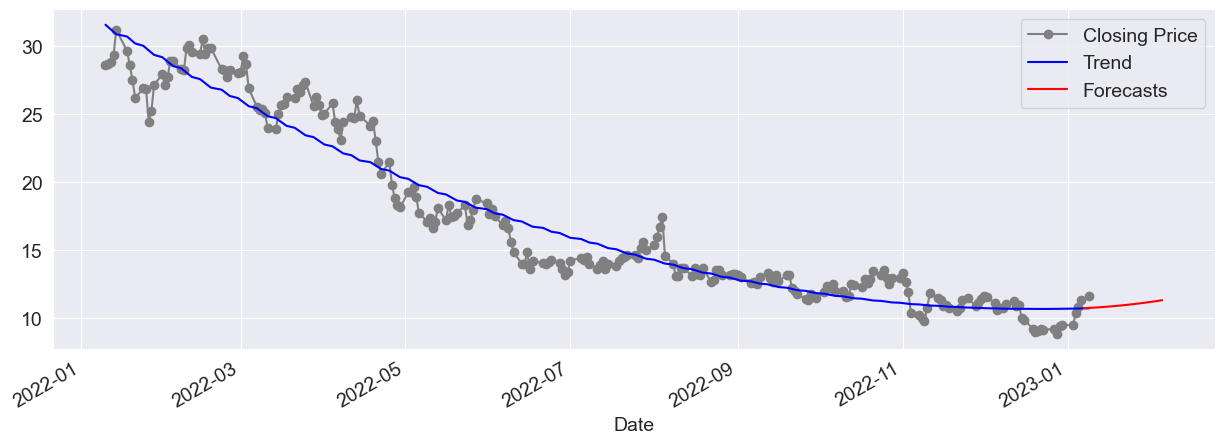

In [17]:
fig, ax = plt.subplots()

# Actual Values
warner.plot(color='grey', marker='o', ax=ax)

# Trend
y_pred.plot(color='blue', ax=ax)

# Forecasts
y_fore.plot(color='red', ax=ax);

# Hybrid Models Usage  

Firstly, series will be detrended (using LinearRegression()); then the XGBRegressor will be used on the residuals.

Splitting the X and the y on the month basis.
Data until 24-10-2022 will be included in the training set, others will be part of the test set.

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

Checking the sets.

In [19]:
X_train

,const,trend,trend_squared
Date,,,
2022-01-10,1.0,1.0,1.0
2022-01-11,1.0,2.0,4.0
2022-01-12,1.0,3.0,9.0
2022-01-13,1.0,4.0,16.0
2022-01-14,1.0,5.0,25.0
...,...,...,...
2022-10-19,1.0,196.0,38416.0
2022-10-20,1.0,197.0,38809.0
2022-10-21,1.0,198.0,39204.0


In [20]:
X_test.head()

,const,trend,trend_squared
Date,,,
2022-10-26,1.0,201.0,40401.0
2022-10-27,1.0,202.0,40804.0
2022-10-28,1.0,203.0,41209.0
2022-10-31,1.0,204.0,41616.0
2022-11-01,1.0,205.0,42025.0


In [21]:
print('X_train shape: {}'.format(X_train.shape))
print('X_test shape: {}'.format(X_test.shape))

X_train shape: (200, 3)
X_test shape: (51, 3)


In [22]:
y_train

Date
2022-01-10    28.590000
2022-01-11    28.680000
2022-01-12    28.790001
2022-01-13    29.340000
2022-01-14    31.180000
                ...    
2022-10-19    12.610000
2022-10-20    12.920000
2022-10-21    13.490000
2022-10-24    13.180000
2022-10-25    13.570000
Name: Closing Price, Length: 200, dtype: float64

In [23]:
y_test.head()

Date
2022-10-26    13.00
2022-10-27    12.49
2022-10-28    12.95
2022-10-31    13.00
2022-11-01    13.35
Name: Closing Price, dtype: float64

Model creation.

In [24]:
# Creating the Model
lin_model = LinearRegression(fit_intercept=False)
lin_model.fit(X_train, y_train)

# Storing the Predictions (y_pred --> training set; y_fore --> test set)
y_pred = pd.DataFrame(lin_model.predict(X_train), columns=['Predictions'], index=X_train.index)
y_fore = pd.DataFrame(lin_model.predict(X_test), columns=['Forecasts'], index=X_test.index)

Plotting the results.

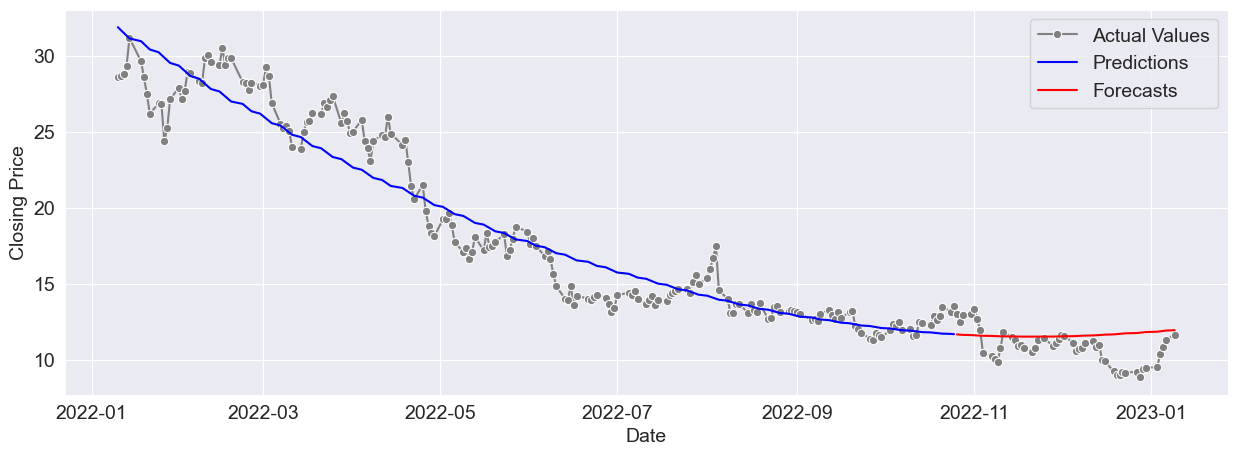

In [25]:
# Actual Values
sns.lineplot(data=warner, x=warner.index, y='Closing Price', color='grey', marker='o')

# Predictions
sns.lineplot(data=y_pred, x=y_pred.index, y='Predictions', color='blue')

# Forecasts
sns.lineplot(data=y_fore, x=y_fore.index, y='Forecasts', color='red')
plt.legend(['Actual Values', 'Predictions', 'Forecasts']);

Second part using XGBRegressor.  

Firstly, some features must be created.

In [26]:
warner['Year'] = pd.to_datetime(warner.index).year
warner['Month'] = pd.to_datetime(warner.index).month
warner['DayOfWeek'] = pd.to_datetime(warner.index).dayofweek

warner

,Closing Price,Year,Month,DayOfWeek
Date,,,,
2022-01-10,28.590000,2022,1,0
2022-01-11,28.680000,2022,1,1
2022-01-12,28.790001,2022,1,2
2022-01-13,29.340000,2022,1,3
2022-01-14,31.180000,2022,1,4
...,...,...,...,...
2023-01-03,9.540000,2023,1,1
2023-01-04,10.380000,2023,1,2
2023-01-05,10.860000,2023,1,3


Defining X and y.

In [27]:
X = warner.drop(columns='Closing Price')
y = warner['Closing Price']

In [28]:
X.head()

,Year,Month,DayOfWeek
Date,,,
2022-01-10,2022,1,0
2022-01-11,2022,1,1
2022-01-12,2022,1,2
2022-01-13,2022,1,3
2022-01-14,2022,1,4


In [29]:
y.head()

Date
2022-01-10    28.590000
2022-01-11    28.680000
2022-01-12    28.790001
2022-01-13    29.340000
2022-01-14    31.180000
Name: Closing Price, dtype: float64

Splitting.

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, shuffle=False)

In [31]:
X_train

,Year,Month,DayOfWeek
Date,,,
2022-01-10,2022,1,0
2022-01-11,2022,1,1
2022-01-12,2022,1,2
2022-01-13,2022,1,3
2022-01-14,2022,1,4
...,...,...,...
2022-10-19,2022,10,2
2022-10-20,2022,10,3
2022-10-21,2022,10,4


In [32]:
X_test.head()

,Year,Month,DayOfWeek
Date,,,
2022-10-26,2022,10,2
2022-10-27,2022,10,3
2022-10-28,2022,10,4
2022-10-31,2022,10,0
2022-11-01,2022,11,1


In [33]:
y_train

Date
2022-01-10    28.590000
2022-01-11    28.680000
2022-01-12    28.790001
2022-01-13    29.340000
2022-01-14    31.180000
                ...    
2022-10-19    12.610000
2022-10-20    12.920000
2022-10-21    13.490000
2022-10-24    13.180000
2022-10-25    13.570000
Name: Closing Price, Length: 200, dtype: float64

In [34]:
y_test.head()

Date
2022-10-26    13.00
2022-10-27    12.49
2022-10-28    12.95
2022-10-31    13.00
2022-11-01    13.35
Name: Closing Price, dtype: float64

Creating the residuals.

In [35]:
y_resid = y_train - y_pred.squeeze()
y_resid

Date
2022-01-10   -3.295704
2022-01-11   -3.019825
2022-01-12   -2.724798
2022-01-13   -1.990626
2022-01-14    0.032695
                ...   
2022-10-19    0.836892
2022-10-20    1.166443
2022-10-21    1.755140
2022-10-24    1.462986
2022-10-25    1.869977
Length: 200, dtype: float64

Creating the model to fit with the residuals.

In [36]:
from xgboost import XGBRegressor

# Creating the Model
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_resid)

# Adding the predicted residuals to the trend
y_pred_xgb = xgb_model.predict(X_train) + y_pred.squeeze()
y_fore_xgb = xgb_model.predict(X_test) + y_fore.squeeze()

In [37]:
y_pred_xgb

Date
2022-01-10    29.182582
2022-01-11    29.182325
2022-01-12    28.043806
2022-01-13    28.139424
2022-01-14    28.952001
                ...    
2022-10-19    12.046482
2022-10-20    12.521832
2022-10-21    12.524337
2022-10-24    12.200024
2022-10-25    12.440093
Name: Predictions, Length: 200, dtype: float64

In [38]:
y_fore_xgb.head()

Date
2022-10-26    11.957257
2022-10-27    12.436872
2022-10-28    12.443642
2022-10-31    12.123594
2022-11-01    12.367927
Name: Forecasts, dtype: float64

Plotting the results.

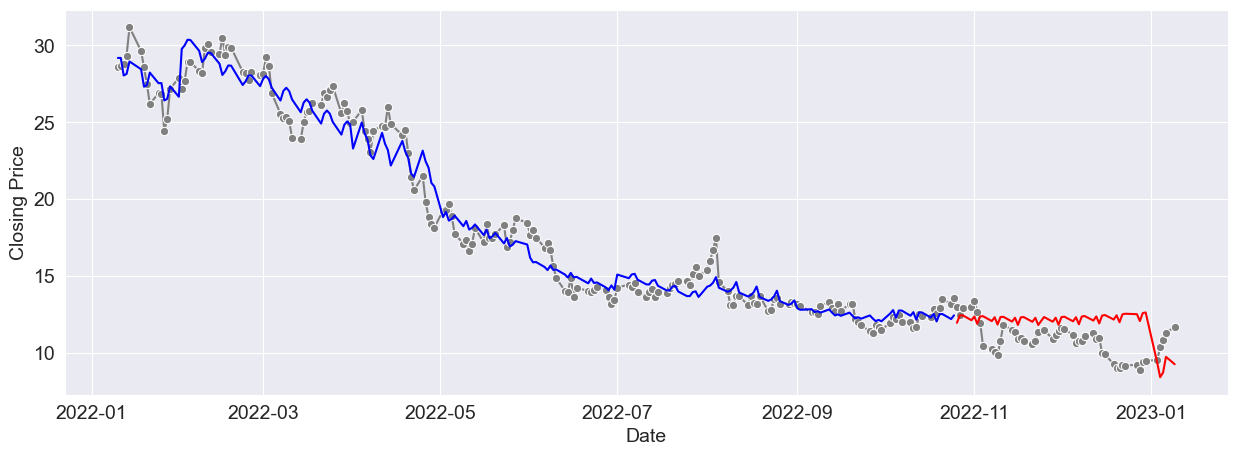

In [39]:
# Actual Values
sns.lineplot(data=warner, x=warner.index, y='Closing Price', marker='o', color='grey')

# Predictions
sns.lineplot(data=y_pred_xgb, x=y_pred_xgb.index, y=y_pred_xgb.values, color='blue')

# Forecasts
sns.lineplot(data=y_fore_xgb, x=y_fore_xgb.index, y=y_fore_xgb.values, color='red');

# Forecasts  

It will be performed some forecasts on a 4-day horizon with 1-day lead time. 

Creation of the lags.

In [40]:
warner.drop(columns=['Year', 'Month', 'DayOfWeek'], inplace=True)
warner

,Closing Price
Date,
2022-01-10,28.590000
2022-01-11,28.680000
2022-01-12,28.790001
2022-01-13,29.340000
2022-01-14,31.180000
...,...
2023-01-03,9.540000
2023-01-04,10.380000
2023-01-05,10.860000


In [41]:
def lag_creation(period):
    new_col = warner['Closing Price'].shift(period)
    warner['Lag_{}'.format(period)] = new_col

In [42]:
[lag_creation(period) for period in range(1,5)]
warner

,Closing Price,Lag_1,Lag_2,Lag_3,Lag_4
Date,,,,,
2022-01-10,28.590000,NaN,NaN,NaN,NaN
2022-01-11,28.680000,28.590000,NaN,NaN,NaN
2022-01-12,28.790001,28.680000,28.590000,NaN,NaN
2022-01-13,29.340000,28.790001,28.680000,28.59,NaN
2022-01-14,31.180000,29.340000,28.790001,28.68,28.59
...,...,...,...,...,...
2023-01-03,9.540000,9.480000,9.430000,8.87,9.23
2023-01-04,10.380000,9.540000,9.480000,9.43,8.87
2023-01-05,10.860000,10.380000,9.540000,9.48,9.43


In [43]:
warner.fillna(0, inplace=True)
warner

,Closing Price,Lag_1,Lag_2,Lag_3,Lag_4
Date,,,,,
2022-01-10,28.590000,0.000000,0.000000,0.00,0.00
2022-01-11,28.680000,28.590000,0.000000,0.00,0.00
2022-01-12,28.790001,28.680000,28.590000,0.00,0.00
2022-01-13,29.340000,28.790001,28.680000,28.59,0.00
2022-01-14,31.180000,29.340000,28.790001,28.68,28.59
...,...,...,...,...,...
2023-01-03,9.540000,9.480000,9.430000,8.87,9.23
2023-01-04,10.380000,9.540000,9.480000,9.43,8.87
2023-01-05,10.860000,10.380000,9.540000,9.48,9.43


Creating the X.

In [44]:
X = warner.drop(columns='Closing Price')
X

,Lag_1,Lag_2,Lag_3,Lag_4
Date,,,,
2022-01-10,0.000000,0.000000,0.00,0.00
2022-01-11,28.590000,0.000000,0.00,0.00
2022-01-12,28.680000,28.590000,0.00,0.00
2022-01-13,28.790001,28.680000,28.59,0.00
2022-01-14,29.340000,28.790001,28.68,28.59
...,...,...,...,...
2023-01-03,9.480000,9.430000,8.87,9.23
2023-01-04,9.540000,9.480000,9.43,8.87
2023-01-05,10.380000,9.540000,9.48,9.43


Creating 4 steps.

In [45]:
def step_creator(step):
    new_col = warner['Closing Price'].shift(-step)
    warner['Step_{}'.format(step)] = new_col

In [46]:
[step_creator(step) for step in range(4)]
warner

,Closing Price,Lag_1,Lag_2,Lag_3,Lag_4,Step_0,Step_1,Step_2,Step_3
Date,,,,,,,,,
2022-01-10,28.590000,0.000000,0.000000,0.00,0.00,28.590000,28.680000,28.790001,29.340000
2022-01-11,28.680000,28.590000,0.000000,0.00,0.00,28.680000,28.790001,29.340000,31.180000
2022-01-12,28.790001,28.680000,28.590000,0.00,0.00,28.790001,29.340000,31.180000,29.639999
2022-01-13,29.340000,28.790001,28.680000,28.59,0.00,29.340000,31.180000,29.639999,28.580000
2022-01-14,31.180000,29.340000,28.790001,28.68,28.59,31.180000,29.639999,28.580000,27.490000
...,...,...,...,...,...,...,...,...,...
2023-01-03,9.540000,9.480000,9.430000,8.87,9.23,9.540000,10.380000,10.860000,11.320000
2023-01-04,10.380000,9.540000,9.480000,9.43,8.87,10.380000,10.860000,11.320000,11.665000
2023-01-05,10.860000,10.380000,9.540000,9.48,9.43,10.860000,11.320000,11.665000,NaN


Step_0 and Closing Price are the same.

Choosing the y.

In [47]:
y = warner.drop(columns=warner.columns[:5])
y.dropna(inplace=True)
y

,Step_0,Step_1,Step_2,Step_3
Date,,,,
2022-01-10,28.590000,28.680000,28.790001,29.340000
2022-01-11,28.680000,28.790001,29.340000,31.180000
2022-01-12,28.790001,29.340000,31.180000,29.639999
2022-01-13,29.340000,31.180000,29.639999,28.580000
2022-01-14,31.180000,29.639999,28.580000,27.490000
...,...,...,...,...
2022-12-28,8.870000,9.430000,9.480000,9.540000
2022-12-29,9.430000,9.480000,9.540000,10.380000
2022-12-30,9.480000,9.540000,10.380000,10.860000


Since X and y have different shapes, only the periods in both dataset will be selected.

In [48]:
final_df = pd.concat([y,X], axis=1).dropna()
final_df

,Step_0,Step_1,Step_2,Step_3,Lag_1,Lag_2,Lag_3,Lag_4
Date,,,,,,,,
2022-01-10,28.590000,28.680000,28.790001,29.340000,0.000000,0.000000,0.00,0.00
2022-01-11,28.680000,28.790001,29.340000,31.180000,28.590000,0.000000,0.00,0.00
2022-01-12,28.790001,29.340000,31.180000,29.639999,28.680000,28.590000,0.00,0.00
2022-01-13,29.340000,31.180000,29.639999,28.580000,28.790001,28.680000,28.59,0.00
2022-01-14,31.180000,29.639999,28.580000,27.490000,29.340000,28.790001,28.68,28.59
...,...,...,...,...,...,...,...,...
2022-12-28,8.870000,9.430000,9.480000,9.540000,9.230000,9.170000,9.23,9.04
2022-12-29,9.430000,9.480000,9.540000,10.380000,8.870000,9.230000,9.17,9.23
2022-12-30,9.480000,9.540000,10.380000,10.860000,9.430000,8.870000,9.23,9.17


Creating the new X and the new y.

In [49]:
X = final_df.drop(columns=final_df.columns[:4])
y = final_df.drop(columns=final_df.columns[4:])

In [50]:
X

,Lag_1,Lag_2,Lag_3,Lag_4
Date,,,,
2022-01-10,0.000000,0.000000,0.00,0.00
2022-01-11,28.590000,0.000000,0.00,0.00
2022-01-12,28.680000,28.590000,0.00,0.00
2022-01-13,28.790001,28.680000,28.59,0.00
2022-01-14,29.340000,28.790001,28.68,28.59
...,...,...,...,...
2022-12-28,9.230000,9.170000,9.23,9.04
2022-12-29,8.870000,9.230000,9.17,9.23
2022-12-30,9.430000,8.870000,9.23,9.17


In [51]:
y

,Step_0,Step_1,Step_2,Step_3
Date,,,,
2022-01-10,28.590000,28.680000,28.790001,29.340000
2022-01-11,28.680000,28.790001,29.340000,31.180000
2022-01-12,28.790001,29.340000,31.180000,29.639999
2022-01-13,29.340000,31.180000,29.639999,28.580000
2022-01-14,31.180000,29.639999,28.580000,27.490000
...,...,...,...,...
2022-12-28,8.870000,9.430000,9.480000,9.540000
2022-12-29,9.430000,9.480000,9.540000,10.380000
2022-12-30,9.480000,9.540000,10.380000,10.860000


## MultiOutput Strategy  

It will be used the LinearRegression() algorithm.

In [52]:
# Splitting X and y
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, shuffle=False)

# Creating the Model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Storing the Results
y_pred = pd.DataFrame(linear_model.predict(X_train), index=y_train.index, columns=y.columns)
y_fore = pd.DataFrame(linear_model.predict(X_test), index=y_test.index, columns=y.columns)

In [53]:
y_pred

,Step_0,Step_1,Step_2,Step_3
Date,,,,
2022-01-10,1.605727,1.789633,1.928428,2.065426
2022-01-11,28.721345,28.333663,28.999121,30.575536
2022-01-12,28.344436,29.017033,30.609515,29.263242
2022-01-13,29.511142,31.090753,29.744470,28.654178
2022-01-14,28.581936,28.358305,28.179181,28.008729
...,...,...,...,...
2022-10-17,13.037175,13.076382,13.119955,13.075051
2022-10-18,12.962187,13.023832,12.979065,12.945313
2022-10-19,13.449809,13.441093,13.444450,13.476039


In [54]:
y_train

,Step_0,Step_1,Step_2,Step_3
Date,,,,
2022-01-10,28.590000,28.680000,28.790001,29.340000
2022-01-11,28.680000,28.790001,29.340000,31.180000
2022-01-12,28.790001,29.340000,31.180000,29.639999
2022-01-13,29.340000,31.180000,29.639999,28.580000
2022-01-14,31.180000,29.639999,28.580000,27.490000
...,...,...,...,...
2022-10-17,12.320000,12.880000,12.610000,12.920000
2022-10-18,12.880000,12.610000,12.920000,13.490000
2022-10-19,12.610000,12.920000,13.490000,13.180000


In [55]:
y_fore.head()

,Step_0,Step_1,Step_2,Step_3
Date,,,,
2022-10-24,14.006043,13.989210,14.020146,14.034645
2022-10-25,13.728066,13.765418,13.766194,13.701017
2022-10-26,14.108426,14.125018,14.076862,14.078024
2022-10-27,13.521024,13.517806,13.526874,13.474587
2022-10-28,13.076801,13.094470,13.022931,12.997082


Plotting the results.

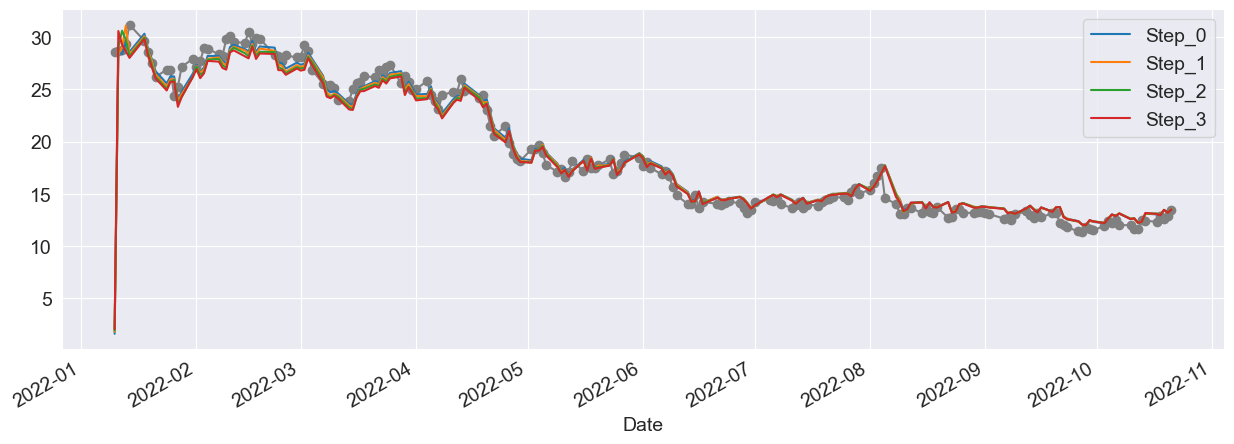

In [56]:
fig, ax = plt.subplots()

# Actual Values
warner['Closing Price'].loc[y_pred.index].plot(color='grey', marker='o')

# y_pred
y_pred.plot(ax=ax);

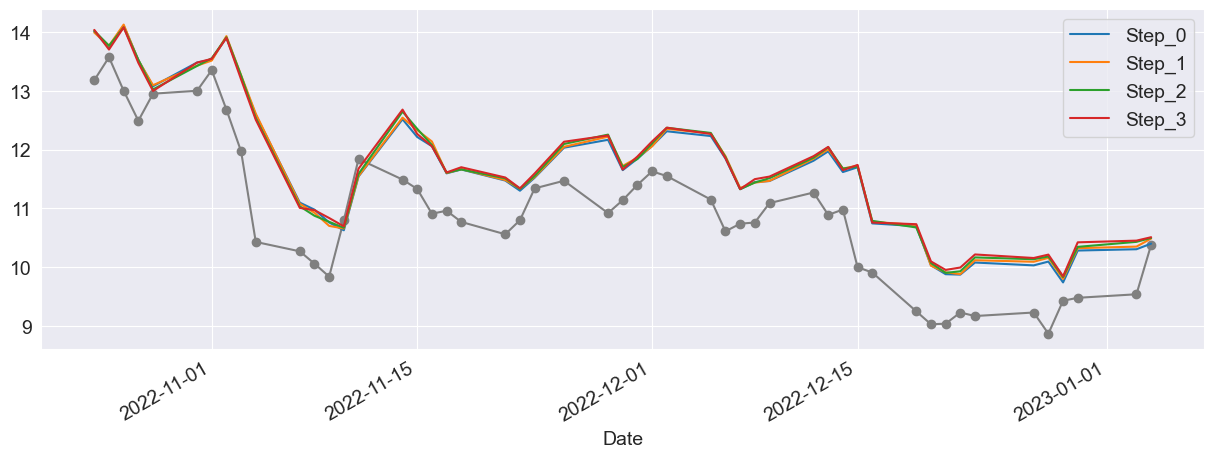

In [57]:
fig, ax = plt.subplots()

# Actual Values
warner['Closing Price'].loc[y_fore.index].plot(color='grey', marker='o')

# y_pred
y_fore.plot(ax=ax);

Checking the RMSE.

In [58]:
from sklearn.metrics import mean_squared_error

print(mean_squared_error(y_train, y_pred, squared=False))
print(mean_squared_error(y_test, y_fore, squared=False))

2.2493954848295834
1.1718153435102057


The RMSE is quite good. The biggest mistake was done on the first observation.

## Direct Strategy  

Direct Strategy with XGBRegressor.

In [59]:
from sklearn.multioutput import MultiOutputRegressor

xgb_multi = MultiOutputRegressor(XGBRegressor())
xgb_multi.fit(X_train, y_train)

y_pred = pd.DataFrame(xgb_multi.predict(X_train), index=X_train.index, columns=y.columns)
y_fore = pd.DataFrame(xgb_multi.predict(X_test), index=X_test.index, columns=y.columns)

Plotting the results.

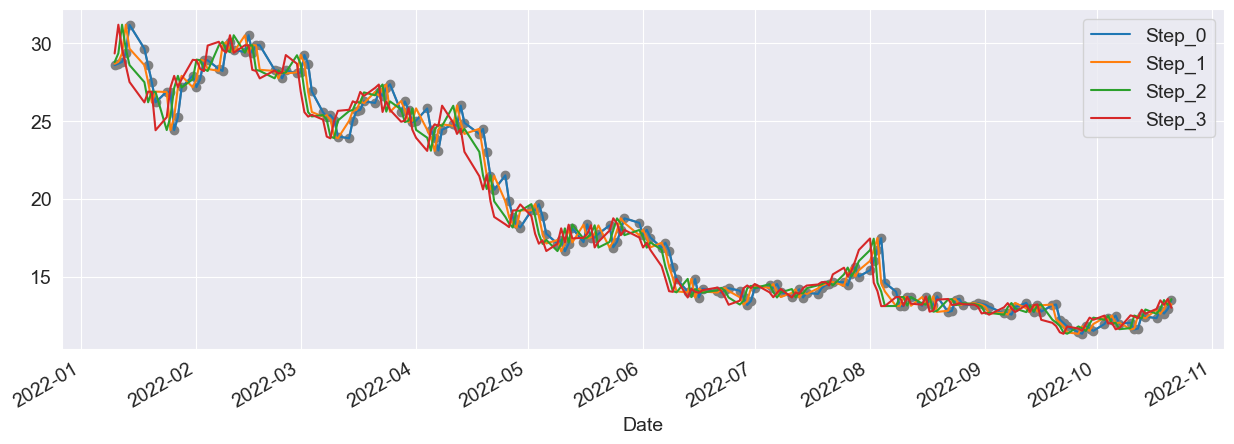

In [60]:
fig, ax = plt.subplots()

# Actual Values
warner['Closing Price'].loc[y_pred.index].plot(color='grey', marker='o', ax=ax)

# Predictions
y_pred.plot(ax=ax);


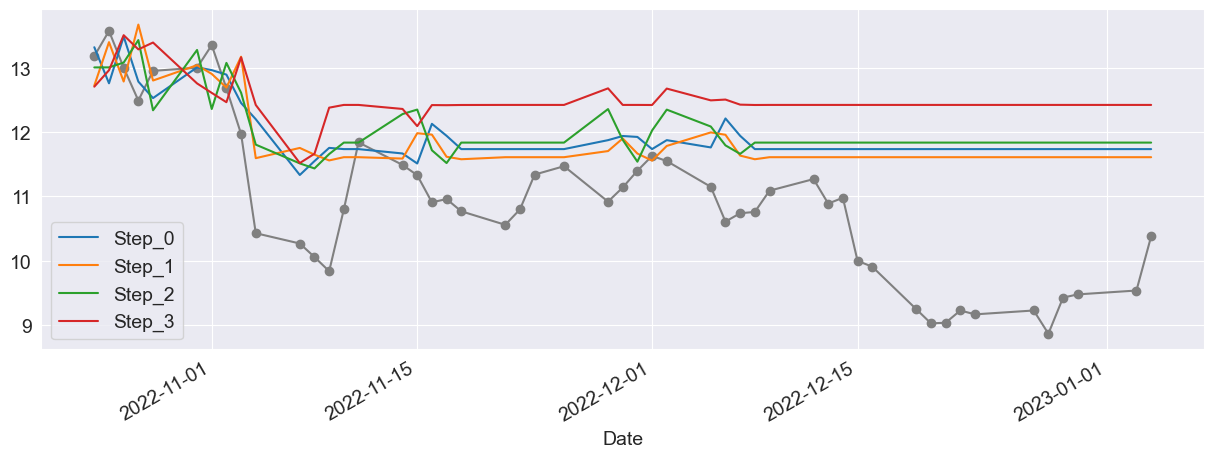

In [61]:
fig, ax = plt.subplots()

# Actual Values
warner['Closing Price'].loc[y_fore.index].plot(color='grey', marker='o', ax=ax)

# Forecasts
y_fore.plot(ax=ax);

It seems to show overfitting.

In [62]:
print(mean_squared_error(y_train, y_pred, squared=False))
print(mean_squared_error(y_test, y_fore, squared=False))

0.01212430947917341
1.5722342202840085
